In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy

import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
from glob import glob
from skimage.transform import resize
from matplotlib.patches import Rectangle

In [2]:
# !wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2024-05-14 02:50:27--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K  --.-KB/s    in 0.1s    

2024-05-14 02:50:28 (4.53 MB/s) - ‘backgrounds.zip’ saved [494000/494000]



In [3]:
# !unzip -n backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

In [4]:
from glob import glob
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for f in background_files:
  # Note: they may not all be the same size
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)

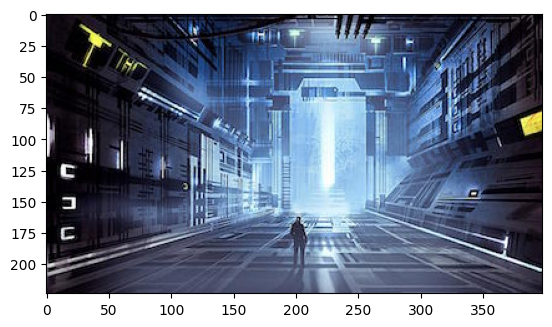

In [5]:
plt.imshow(backgrounds[3])

In [6]:
# !wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png
# !wget -nc https://lazyprogrammer.me/course_files/bulbasaur-tight.png
# !wget -nc https://lazyprogrammer.me/course_files/squirtle-tight.png

--2024-05-14 02:50:39--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2024-05-14 02:50:39 (67.1 MB/s) - ‘charmander-tight.png’ saved [3952/3952]

--2024-05-14 02:50:39--  https://lazyprogrammer.me/course_files/bulbasaur-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3435 (3.4K) [image/png]
Saving to: ‘bulbasaur-tight.png’

bulbasaur-tight.png 100%[===================>]   3.

In [7]:
# path_ch = '/home/notomo/Documents/VSC/Models/ObjectLocalization/charmander-tight.png'
# path_bb = '/home/notomo/Documents/VSC/Models/ObjectLocalization/bulbasaur-tight.png'
# path_sq = '/home/notomo/Documents/VSC/Models/ObjectLocalization/squirtle-tight.png'
path_ch = '/content/charmander-tight.png'
path_bb = '/content/bulbasaur-tight.png'
path_sq = '/content/squirtle-tight.png'
ch = imread(path_ch)
bb = imread(path_bb)
sq = imread(path_sq)

ch = np.array(ch)
bb = np.array(bb)
sq = np.array(sq)

CH_H, CH_W, CH_C = ch.shape
BB_H, BB_W, BB_C = bb.shape
SQ_H, SQ_W, SQ_C = sq.shape

objects = [ch, bb, sq]
objects = [(ch, CH_H, CH_W, CH_C), (bb, BB_H, BB_W, BB_C), (sq, SQ_H, SQ_W, SQ_C)]
classes = ['charmander', 'bulbasaur', 'squirtle']

POKE_DIM = 200

<ipython-input-7-5ce760b04933>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ch = imread(path_ch)
<ipython-input-7-5ce760b04933>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  bb = imread(path_bb)
<ipython-input-7-5ce760b04933>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sq = imread(path_sq)


Height of the object image: 56
Width of the object image:  44
Number of color channels: 4


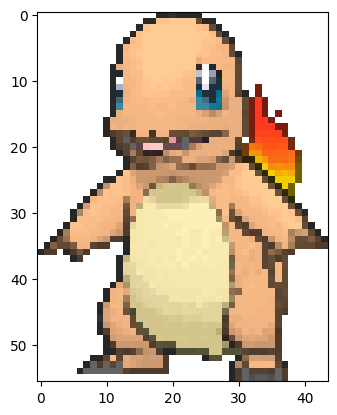

In [8]:
plt.imshow(ch)

print(f'Height of the object image: {CH_H}')
print(f'Width of the object image:  {CH_W}')
print(f'Number of color channels: {CH_C}')

Height of the object image: 48
Width of the object image:  43
Number of color channels: 4


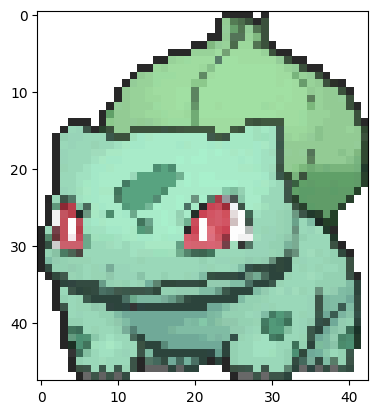

In [9]:
plt.imshow(bb)

print(f'Height of the object image: {BB_H}')
print(f'Width of the object image:  {BB_W}')
print(f'Number of color channels: {BB_C}')

Height of the object image: 54
Width of the object image:  44
Number of color channels: 4


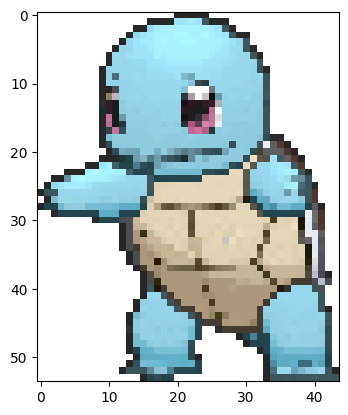

In [10]:
plt.imshow(sq)

print(f'Height of the object image: {SQ_H}')
print(f'Width of the object image:  {SQ_W}')
print(f'Number of color channels: {SQ_C}')

In [37]:
def customloss(y_true, y_pred):
    # target is (x, y, h, w, class 1, class 2, class 3, appear)
    bce1 = binary_crossentropy(y_true[:, :4], y_pred[:, :4])
    cce = categorical_crossentropy(y_true[:, 4:7], y_pred[:, 4:7])
    bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1])

    alpha = 1.5
    beta = 1
    gama = 0.5
    return alpha * bce1 * y_true[:, -1] + beta * cce * y_true[:, -1] + gama * bce2

In [103]:
def make_model():
    vgg = VGG16(input_shape= [POKE_DIM, POKE_DIM, 3],
                include_top=False,
                weights='imagenet')

    # n = len(vgg.layers)
    # for i in range(n-3):
    #     vgg.layers[i].trainable = False

    x = Flatten()(vgg.output)
    # x = Dense(units=1024, activation='relu')(x)
    # x = Dropout(0.2)(x)
    # x = BatchNormalization()(x)
    # x = Dense(units=512, activation='relu')(x)
    # x = Dropout(0.2)(x)
    # x = BatchNormalization()(x)
    # x = Dense(units=256, activation='relu')(x)
    # x = Dropout(0.2)(x)
    # x = BatchNormalization()(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x1 = Dense(units=4, activation='sigmoid')(x) # x_topleft, y_topleft, height, width
    x2 = Dense(units=3, activation='softmax')(x)
    x3 = Dense(units=1, activation='sigmoid')(x)
    x = Concatenate()([x1, x2, x3])
    model = Model(vgg.input, x)
    model.compile(loss=customloss, optimizer=Adam(lr=0.001))

    return model

In [86]:
def pokemon_generator_multiclass(batch_size=64):
    while True:
        for _ in range(50): # number of batches in each epoch is just random (I chose 50)
            # Generate X - (batch_size, H, W, 3)
            # Generate y  - (batch_size, 4)
            X = np.zeros(shape=(batch_size, POKE_DIM, POKE_DIM, 3))
            y = np.zeros(shape=(batch_size, 8)) # x_top_right, y_top_right, height, width
                                                # class, appear
            for i in range(batch_size):
                bg_idx = np.random.choice(len(backgrounds))
                bg = backgrounds[bg_idx]
                bg_h, bg_w, _ = bg.shape

                # Cut a random part on background image (200x200)
                cut_x = np.random.randint(0, bg_w - POKE_DIM)
                cut_y = np.random.randint(0, bg_h - POKE_DIM)
                X[i] = bg[cut_y:cut_y+POKE_DIM, cut_x:cut_x+POKE_DIM, :].copy()

                appear = (np.random.random() < 0.75)
                if appear:
                    # Choose object
                    obj_idx = np.random.randint(0, 3)
                    obj, H, W, _ = objects[obj_idx]

                    # Resize Object (random)
                    scale = np.random.random() + 0.5
                    new_height, new_width = int(H * scale), int(W * scale)
                    obj = resize(obj, (new_height, new_width),
                                preserve_range=True).astype(np.uint8)

                    # Flip Object
                    if np.random.random() < 0.5:
                        obj = np.fliplr(obj)

                    # Locate the object on background image (at a random location)
                    x0 = np.random.randint(0, POKE_DIM - new_width)
                    y0 = np.random.randint(0, POKE_DIM - new_height)
                    x1 = x0 + new_width
                    y1 = y0 + new_height

                    # Paste Object on background image
                    mask = (obj[:, :, 3] == 0) # find where the object is 0
                    bg_obj = X[i, y0:y1, x0:x1, :] # where we want to place `obj`
                    bg_obj = np.expand_dims(mask, -1) * bg_obj # (h,w,1) x (h,w,3)
                    bg_obj += obj[:, :, :3]
                    X[i, y0:y1, x0:x1, :] = bg_obj

                    y[i, 0] = x0 / POKE_DIM
                    y[i, 1] = y0 / POKE_DIM
                    y[i, 2] = (y1-y0) / POKE_DIM
                    y[i, 3] = (x1-x0) / POKE_DIM

                    y[i, 4 + obj_idx] = 1

                y[i, -1] = appear
            yield X / 255., y

[0. 0. 0. 0. 0. 0. 0. 0.]
percent no obj: 0.1875
percent charmander: 0.296875
percent bulbasaur: 0.1875
percent squirtle: 0.328125


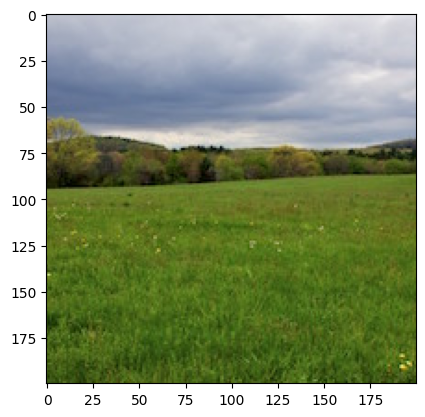

In [87]:
xx = None
yy = None
for x, y in pokemon_generator_multiclass():
  xx, yy = x, y
  break

n = yy.shape[0]
idx = np.random.randint(n)
plt.imshow(xx[idx]);
print(yy[idx])
print("percent no obj:", (yy[:,7] == 0).sum() / n)
print("percent charmander:", yy[:,4].sum() / n)
print("percent bulbasaur:", yy[:,5].sum() / n)
print("percent squirtle:", yy[:,6].sum() / n)

In [104]:
model = make_model()
model.fit_generator(
    pokemon_generator_multiclass(),
    steps_per_epoch=50,
    epochs=15
)

<ipython-input-104-1700bebb4765>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/15
50/50 [==============================] - 40s 710ms/step - loss: 2.0539
Epoch 2/15
50/50 [==============================] - 35s 696ms/step - loss: 1.6833
Epoch 3/15
50/50 [==============================] - 34s 682ms/step - loss: 1.2877
Epoch 4/15
50/50 [==============================] - 34s 687ms/step - loss: 1.0622
Epoch 5/15
50/50 [==============================] - 34s 689ms/step - loss: 0.9766
Epoch 6/15
50/50 [==============================] - 34s 687ms/step - loss: 0.9148
Epoch 7/15
50/50 [==============================] - 34s 688ms/step - loss: 0.8993
Epoch 8/15
50/50 [==============================] - 34s 689ms/step - loss: 0.8116
Epoch 9/15
50/50 [==============================] - 35s 690ms/step - loss: 0.7438
Epoch 10/15
50/50 [==============================] - 34s 689ms/step - loss: 0.6721
Epoch 11/15
50/50 [==============================] - 34s 688ms/step - loss: 0.6534
Epoch 12/15
50/50 [==============================] - 34s 687ms/step - loss: 0.6249
Epoch 13/15
5

true: 36 11 60 41 squirtle
1/1 [==============================] - 0s 28ms/step
pred: 36 11 60 42 squirtle


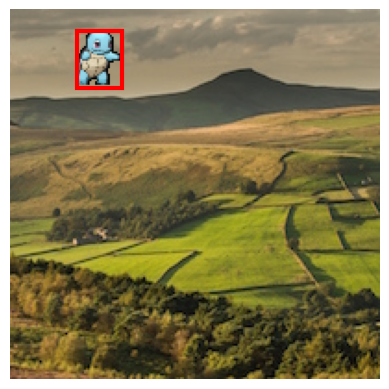

In [113]:
# Function to make prediction, everytime want to test the model, just run this function
def pokemon_predict_multiclass():
    X = np.zeros(shape=(POKE_DIM, POKE_DIM, 3))
    y = np.zeros(shape=(8)) # x_top_right, y_top_right, height, width
                            # class 1, class 2, class 3, appear
    bg_idx = np.random.choice(len(backgrounds))
    bg = backgrounds[bg_idx]
    bg_h, bg_w, _ = bg.shape

    # Cut a random part on background image (200x200)
    cut_x = np.random.randint(0, bg_w - POKE_DIM)
    cut_y = np.random.randint(0, bg_h - POKE_DIM)
    X = bg[cut_y:cut_y+POKE_DIM, cut_x:cut_x+POKE_DIM, :].copy()

    appear = (np.random.random() < 0.75)
    if appear:
        # Choose object
        obj_idx = np.random.randint(0, 3)
        obj, H, W, _ = objects[obj_idx]

        # Resize Object (random)
        scale = np.random.random() + 0.5
        new_height, new_width = int(H * scale), int(W * scale)
        obj = resize(obj, (new_height, new_width),
                    preserve_range=True).astype(np.uint8)

        # Flip Object
        if np.random.random() < 0.5:
            obj = np.fliplr(obj)

        # Locate the object on background image (at a random location)
        x0 = np.random.randint(0, POKE_DIM - new_width)
        y0 = np.random.randint(0, POKE_DIM - new_height)
        x1 = x0 + new_width
        y1 = y0 + new_height

        # Paste Object on background image
        mask = (obj[:, :, 3] == 0) # find where the object is 0
        bg_obj = X[y0:y1, x0:x1, :] # where we want to place `obj`
        bg_obj = np.expand_dims(mask, -1) * bg_obj # (h,w,1) x (h,w,3)
        bg_obj += obj[:, :, :3]
        X[y0:y1, x0:x1, :] = bg_obj
        actual_class = classes[obj_idx]
        print("true:", x0, y0, x1, y1, actual_class)

        y[0] = x0 / POKE_DIM
        y[1] = y0 / POKE_DIM
        y[2] = (y1-y0) / POKE_DIM
        y[3] = (x1-x0) / POKE_DIM

        y[4 + obj_idx] = 1

    y[-1] = appear

    X = np.expand_dims(X, axis=0) / 255.
    y = np.expand_dims(y, axis=0)
    prediction = model.predict(X)[0]

    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(X[0])

    if prediction[-1] > 0.5:
        prediction = prediction * POKE_DIM
        x1_pred = int(prediction[0])
        y1_pred = int(prediction[1])
        y2_pred = int(y1_pred + prediction[2])
        x2_pred = int(x1_pred + prediction[3])
        class_pred_idx = np.argmax(prediction[4:7])
        class_pred = classes[class_pred_idx]
        print("pred:", x1_pred, y1_pred, x2_pred, y2_pred, class_pred)
        rect = Rectangle((x1_pred, y1_pred),
                        height=y2_pred - y1_pred, width=x2_pred - x1_pred,
                        edgecolor='r',
                        linewidth=3,
                        facecolor='none')

        ax.add_patch(rect)
    else:
        print('pred: No Object')

    plt.show()


# Run function
pokemon_predict_multiclass()